# Create stellar template from reference spectrum

Sometimes, you do not have any template observations for a specific star, or you simply possess a nice high-resolution/high-$S/N$ reference spectrum of a star that you would like to use as stellar template instead of the deconvolved version. E.g. with the SONG spectrograph, we have a large number of Arcturus and Solar observations, for which we can make use of the Arcturus/Solar spectral atlases by [Hinkle et al. (2000)](https://ui.adsabs.harvard.edu/abs/2000vnia.book.....H/abstract), which we also use as reference spectra in **pyodine**. Here we demonstrate how to create a "deconvolved" stellar template for Arcturus (and tailored to the SONG instrument) from this source.

Another great collection of suitable reference spectra is the one of [PEPSI](https://pepsi.aip.de/?page_id=552) (see also [Strassmeier, Ilyin & Weber (2018)](https://ui.adsabs.harvard.edu/abs/2018A&A...612A..45S/abstract) for more information). All you need to do to use these is download them, change the 'ref_pathname' further below and adapt the key names when extracting the data from the FITS files!

In [1]:
# Automatic reloading of imports
%load_ext autoreload
%autoreload 2

import os
import sys
from astropy.io import fits
from astropy.time import Time
from astropy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy import ndimage
from scipy.interpolate import splrep, splev

# Put in the pyodine path on your machine here!
pyodine_path = '/Users/jaklusmeyer/code/NMSU/SONG/pyodine'

sys.path.append(pyodine_path)

import pyodine
import utilities_song_apo

/Users/jaklusmeyer/code/NMSU/SONG/pyodine/pyodine/__init__.py:8: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):
/Users/jaklusmeyer/code/NMSU/SONG/pyodine/pyodine/__init__.py:10: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


NumExpr defaulting to 12 threads.


We load the Arcturus atlas, and clip it down to the wavelengths which are relevant for us (between roughly 4970 and 6250 Å).

In [3]:
# The atlas pathname
ref_pathname = os.path.join(pyodine_path, 'pyodine/reference/arcturus/ardata.fits')

# 'arcturus' for Arcturus, 'solarflux' for the Sun
ref_star = 'arcturus'

with fits.open(ref_pathname) as h:
    # Get wavelength
    ref_wave = h[1].data['wavelength']
    # Get flux
    ref_flux = h[1].data[ref_star]

# Clip it down to the part relevant for us
wave_limits = (4970., 6250.)

ind = np.where(np.logical_and(ref_wave>wave_limits[0], ref_wave<wave_limits[1]))
ref_wave = ref_wave[ind[0]]
ref_flux = ref_flux[ind[0]]

This flux data contains telluric lines, which we obviously want to discard/correct for. Here we take advantage of the fact that the flux values are around 1 in the continuum, normal absorption lines have flux values between 0 and 1, and telluric lines extend down to roughly -1. So we define a function which identifies connected array indices with flux values below a threshold of -0.5, and returns a mask where indices of a telluric line all have the same positive integer number.

Nr. of identified tellurics:  33


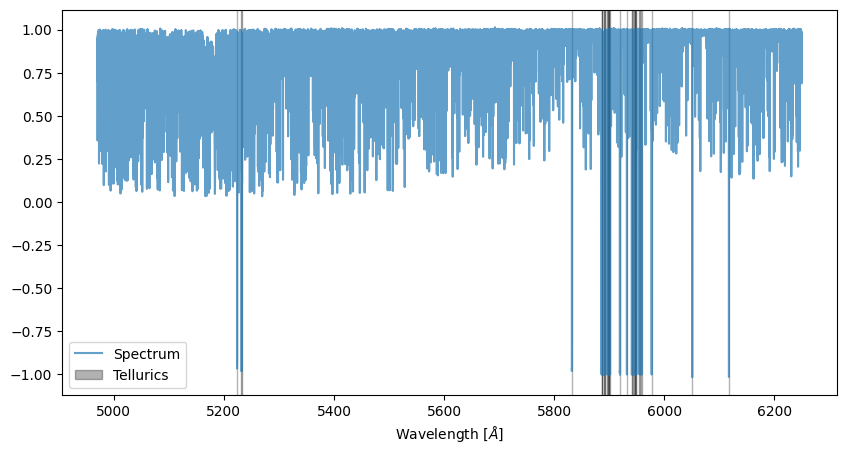

In [4]:
# Function to identify the telluric lines in the atlas
def identify_objects(image, threshold):
    """Modified from the internet: Returns a mask of numbers, 
    with the lowest value being the background (0), then 1 and 2 etc...
    
    http://stackoverflow.com/questions/5298884/finding-number-of-colored-shapes-from-picture-using-python
    """
    # Find connected components
    labeled, nr_objects = ndimage.label(image < threshold)
     
    return labeled, nr_objects

# Here we go: tellurics are around -1 in the spectrum (so below threshold of -0.5)
tell_mask, nr_tellurics = identify_objects(ref_flux, -0.5)
print("Nr. of identified tellurics: ", nr_tellurics)

# Plot spectrum and shade identified tellurics to check
fig = plt.figure(figsize=(10,5))
plt.plot(ref_wave, ref_flux, alpha=0.7)
for i in range(nr_tellurics):
    plt.axvspan(ref_wave[np.where(tell_mask==i+1)[0][0]], 
                ref_wave[np.where(tell_mask==i+1)[0][-1]], 
                color='k', alpha=0.3)
plt.legend(['Spectrum', 'Tellurics'])
plt.xlabel(r'Wavelength [$\AA$]')
#plt.xlim(5220, 5240)
plt.show()

Now we want to fix these tellurics. They are not very wide, so we simply interpolate through the telluric regions from the border regions. (In some cases, there are identified regions where not all flux values are exactly -1 - in these cases it seems that we can simply "mirror up" the flux, i.e. multiply it by -1, to nicely fill the gaps in the spectrum).

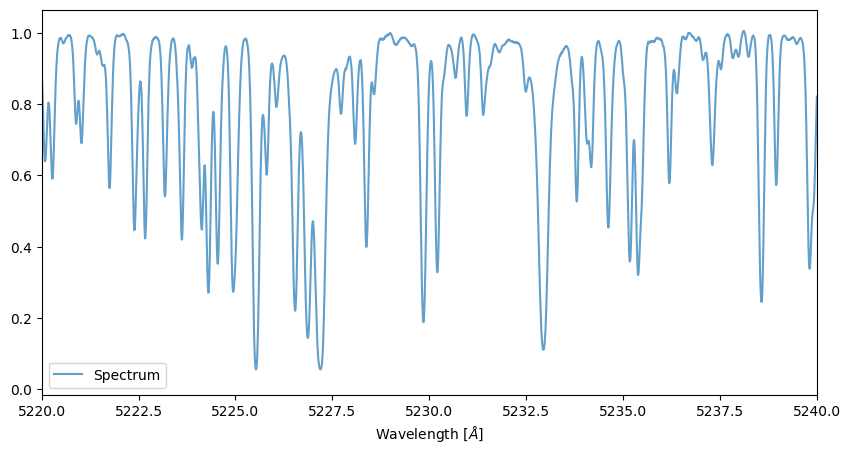

In [7]:
# Now loop through the telluric features and "fix" them (through interpolation)
ref_flux2 = ref_flux.copy()
for i in range(nr_tellurics):
    ind = np.where(tell_mask==i+1)
    tell_wave = ref_wave[ind]
    tell_flux = ref_flux[ind]
    # If any flux value is unequal to one, try to just "mirror up"
    if any(tell_flux != -1.):
        ref_flux2[ind] = tell_flux * -1
    # Otherwise try to interpolate between the left and right edge
    else:
        # Linear, not so fancy (but might just be enough, as it gets down-sampled anyway)
        #ref_flux2[ind] = np.linspace(ref_flux[ind[0][0]-1], ref_flux[ind[0][-1]+1], len(ind[0])+2)[1:-1]
        
        # Or try a smoother interpolation between left and right edge (this works nicely)
        ind_left = np.arange(ind[0][0]-20, ind[0][0])
        ind_right = np.arange(ind[0][-1]+1, ind[0][-1]+21)
        ext_wave = ref_wave[np.concatenate((ind_left, ind_right), axis=0)]
        ext_flux = ref_flux[np.concatenate((ind_left, ind_right), axis=0)]
        
        tck = splrep(ext_wave, ext_flux, s=0)
        int_flux = splev(tell_wave, tck, der=0)
        ref_flux2[ind] = int_flux


# Again plot to check
fig = plt.figure(figsize=(10,5))
plt.plot(ref_wave, ref_flux2, alpha=0.7)
plt.legend(['Spectrum'])
plt.xlabel(r'Wavelength [$\AA$]')
plt.xlim(5220, 5240)
plt.show()

Alright, we have prepared the atlas. Next, we will have to split it into appropriate chunks to finally save it as a `StellarTemplate_Chunked` object. But to do this nicely, we need information about the typical orders and wavelength vectors within each order of the instrument that we're building the template for. So, we will load an observation of that instrument - SONG in our case - and simply choose a $\sigma$Dra observation from the tutorial for that. Then we initialize a Normalizer with the Arcturus reference spectrum and use it to estimate the velocities of the $\sigma$Dra observation and our prepared Arcturus atlas relative to it - obviously, the latter should come out close to 0 m/s.

In [5]:
# Load a Sigma Draconis observation
obs_filepath = os.path.join(pyodine_path, 
    'tutorial_data/sigdra_obs_tutorial/s1_2015-05-02T03-48-48_ext.fits')
obs = utilities_song.load_pyodine.ObservationWrapper(obs_filepath)

# Load normalizer (to find reference velocity of observation and template)
nmz = pyodine.template.normalize.SimpleNormalizer(reference='arcturus')
# Order range 4 to 17 should be redward of the I2 region
obs_velocity = nmz.guess_velocity(obs[4:17])
arc_velocity = nmz.guess_velocity(pyodine.components.Spectrum(ref_flux2, ref_wave))
print('Observation velocity: {:.2f} m/s'.format(obs_velocity))
print('Arcturus spec velocity: {:.2f} m/s'.format(arc_velocity))

Observation velocity: 26631.51 m/s
Arcturus spec velocity: 12.70 m/s


Looks good. Now we need to find the orders within the observation that cover the I2 absorption region. For SONG, we can simply look into `utilities_song.pyodine_parameters.Template_Parameters` and use the numbers from the 'temp_order_range' - that is 18 to 41. However, as you see below, we need to correct the orders downard by 1 to receive the correct wavelength range - this is because for some observations the spectral format shifted so that orders fell out of the detector region. No problems though, in the observation modelling **pyodine** always checks for that through a cross-correlation and automatically corrects the orders mapping if necessary!

In [6]:
# First and last order of observation to use
# (these are from the Template_Parameters for SONG)
first_order = 18
last_order  = 41
# Order correction for this observation
order_correction = -1

print('First order ({}) wavelength limits: {:.2f}-{:.2f}'.format(
    first_order+order_correction, 
    obs[first_order+order_correction].wave[0], 
    obs[first_order+order_correction].wave[-1]))
print('Last order ({}) wavelength limits: {:.2f}-{:.2f}'.format(
    last_order+order_correction, 
    obs[last_order+order_correction].wave[0], 
    obs[last_order+order_correction].wave[-1]))

First order (17) wavelength limits: 4994.14-5037.88
Last order (40) wavelength limits: 6154.39-6208.05


Great! We can now use the reference velocity of the observation to Doppler shift one order into the Arcturus atlas wavelength space - the absorption lines should then fall nicely on top of each other:

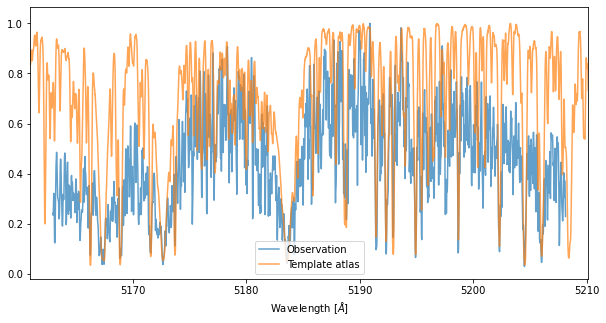

In [7]:
# Calculate Doppler shift of observation
z_obs = obs_velocity / c.value

# Plot this order
plot_order = 21

fig = plt.figure(figsize=(10,5))
plt.plot(obs[plot_order].wave * (1-z_obs), 
         obs[plot_order].flux/np.max(obs[plot_order].flux), alpha=0.7)
plt.plot(ref_wave, ref_flux2, alpha=0.7)
plt.xlim((obs[plot_order].wave * (1-z_obs))[0]-2, (obs[plot_order].wave * (1-z_obs))[-1]+2)
plt.legend(['Observation', 'Template atlas'])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()

Looks perfect by eye. Then, let's finally chunk up the prepared Arcturus atlas! To do that, we need to define a few parameters - most of them we can again look up in `utilities_song.pyodine_parameters.Template_Parameters`:

* pix_offset0: The first chunk in each order starts at that pixel.
* chunk_width: The width of the chunks in pixels (observation pixels, not oversampled).
* chunk_padding: The pixel padding left and right of each template chunk (again: observation pixels).
* npix_spec: The pixel length of observation orders.
* temp_oversampling: The oversampling of the final template chunks with respect to the observation sampling.
* chunks_per_order: The desired number of chunks in each order.

The routine below then splits each order of the example observation into the desired number of chunks with desired width, and then transforms that to the reference spectrum (Arcturus) to create the template chunks with the desired oversampling. When running it, you will notice a warning that no more than 21 chunks can be fitted into one order without cutting down. This is because: 

$22 \, \mathrm{chunks} \cdot 91 \, \mathrm{pixel} + 2 \cdot 25 \, \mathrm{pixel\_padding} = 2052 \, \mathrm{pixel}$,

which is more than the 2048 pixels of an order. So, the last chunk within each order is corrected in total width (including padding) so that it does not extend past the order edges. Which should not really bother us, as we chose plenty of pixel padding in the first place, and a little less will not harm the fitter later.

In [8]:
# Chunk up the spectrum

pix_offset0 = 30        # start chunking from this pixel
chunk_width = 91        # width of the chunks in pixels
chunk_padding = 25      # pixel padding of the chunks
npix_spec = 2048        # length of orders in pixels
temp_oversampling = 10  # which template oversampling to use
chunks_per_order = 22   # desired chunks per order

# Number of chunks per order
max_chunks_per_order = int((npix_spec - 2 * chunk_padding) / chunk_width)
if chunks_per_order > max_chunks_per_order:
    print('Warning! Max. nr. of chunks without cutting down is {}!'.format(
            max_chunks_per_order))

template_chunks = []

# Loop through the orders defined above
for o in range(first_order+order_correction, last_order+order_correction+1):
    #print('Order: ', o)
    # First compute the wavelength of the starting pixel
    obs_wave_pixoff = obs[o].wave[pix_offset0]
    ref_wave_pixoff = obs_wave_pixoff #* (1 - z_bary)
    ref_ind_pixoff  = np.argmin(np.abs(ref_wave - ref_wave_pixoff))
    
    obs_ch_endpix = pix_offset0
    
    # Now loop through the number of chunks in this order
    for i in range(chunks_per_order):
        #print('Chunk: ', i)
        #print(obs_ch_endpix)
        
        # First create the chunk with chunk_width in observation 
        # (and also include the padding)
        if obs_ch_endpix + chunk_width + chunk_padding > npix_spec:
            print('Order {}, chunk {}: Extends past order edge.'.format(o, i))
            padding2 = npix_spec - (obs_ch_endpix + chunk_width)
            print('Correcting full width (+padding) to: {}'.format(chunk_width+2*padding2))
            obs_ch_pix = obs_ch_endpix + np.arange(- padding2, chunk_width + padding2)
        else:
            padding2 = chunk_padding
            obs_ch_pix = obs_ch_endpix + np.arange(- chunk_padding, chunk_width + chunk_padding)
        obs_ch_endpix = obs_ch_pix[-1] - chunk_padding + 1
        obs_ch_wave = obs[o].wave[obs_ch_pix]
        
        # Guess the wavelength parameters for that chunk
        n = len(obs_ch_pix)
        p = np.polyfit(np.arange(-(n // 2), n - n // 2), obs_ch_wave, 1)
        obs_ch_w0 = p[1]
        obs_ch_w1 = p[0]
        
        # Now do the same for the reference spectrum
        ref_ch_pix_start = np.argmin(np.abs(obs_ch_wave[0] - ref_wave))
        ref_ch_pix_end = np.argmin(np.abs(obs_ch_wave[-1] - ref_wave))
        ref_ch_pix = np.arange(ref_ch_pix_start, ref_ch_pix_end+1)
        ref_ch_wave = ref_wave[ref_ch_pix]
        ref_ch_flux = ref_flux2[ref_ch_pix]
        
        # Bin down the wavelengths and flux of the reference spectrum
        # to the desired template oversampling
        chunk_length = (chunk_width-1 + 2*padding2) * temp_oversampling + 1
        temp_ch_pix = np.linspace(ref_ch_pix[0], ref_ch_pix[-1], chunk_length)
        temp_ch_wave = pyodine.lib.misc.rebin(ref_ch_pix, ref_ch_wave, temp_ch_pix)
        temp_ch_flux = pyodine.lib.misc.rebin(ref_ch_pix, ref_ch_flux, temp_ch_pix)
        # Guess the wavelength parameters
        n = len(temp_ch_pix)
        p = np.polyfit(np.arange(-(n // 2), n - n // 2), temp_ch_wave, 1)
        temp_ch_w0 = p[1]
        temp_ch_w1 = p[0]
        
        # Analytic chunk weights
        chunk_weights = pyodine.lib.misc.analytic_chunk_weights(temp_ch_flux, temp_ch_w0, temp_ch_w1)
        
        pix0 = obs_ch_pix[0] + padding2
        order = o
        w0 = temp_ch_w0
        w1 = temp_ch_w1 * temp_oversampling # to account for the oversampling
        
        # For fine pixel grid in TemplateChunk, use the one corresponding to the observation
        pix_fine = np.linspace(obs_ch_pix[0], obs_ch_pix[-1], chunk_length)
        
        # Initialize the TemplateChunk and append it to our list
        temp_chunk = pyodine.components.TemplateChunk(
            temp_ch_flux, temp_ch_wave, pix_fine, w0, w1, 
            order, pix0, chunk_weights)
        template_chunks.append(temp_chunk)

Warning! Max. nr. of chunks without cutting down is 21!
Order 17, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 18, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 19, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 20, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 21, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 22, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 23, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 24, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 25, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 26, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 123
Order 27, chunk 21: Extends past order edge.
Correcting full width (+padding) to: 12

Alright, to test whether this worked fine lets overplot one template chunk with the observation spectrum:

Length of template chunk (oversampled): 1401


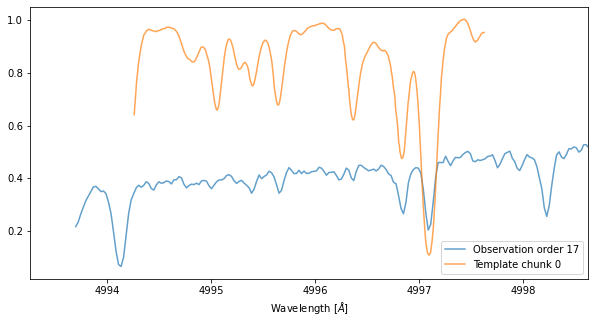

In [9]:
# Overplot template chunk to check
plot_chunk = 0
plot_order = first_order + order_correction

print('Length of template chunk (oversampled):', len(template_chunks[plot_chunk].flux))

fig = plt.figure(figsize=(10,5))
plt.plot(obs[plot_order].wave * (1-z_obs), 
         obs[plot_order].flux/np.max(obs[plot_order].flux), alpha=0.7)
plt.plot(template_chunks[plot_chunk].wave, template_chunks[plot_chunk].flux, alpha=0.7)
plt.xlim(template_chunks[plot_chunk].wave[0]-1, template_chunks[plot_chunk].wave[-1]+1)
plt.legend(['Observation order {}'.format(plot_order), 
            'Template chunk {}'.format(plot_chunk)])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()

Ok. All that's left to do now is to pack the template chunks into a `StellarTemplate_Chunked` object format and save it. We are doing that manually here, i.e. simply creating a HDF5-file with the required format.

In [10]:
# Pack the template into a HDF5-file as compatible with StellarTemplate_Chunked object

# This is not really important - but I always put in the time of template creation
date = Time.now()

# Filename and starname ('Arcturus' or 'Sun')
temp_filepath = os.path.join(pyodine_path, 
        'tutorial_data/temp_arcturus_atlas.h5')
starname = 'Arcturus'

with h5py.File(temp_filepath, 'w') as h:
    h.create_dataset('/orig_filename', data=temp_filepath)
    h.create_dataset('/starname', data=starname)
    h.create_dataset('/time_start', data=date.isot)
    h.create_dataset('/velocity_offset', data=arc_velocity)
    # The barycentric velocity of the reference spectrum is 0.
    h.create_dataset('/bary_vel_corr', data=0.)
    h.create_dataset('/osample', data=temp_oversampling)
    h.create_dataset('/orders', data=np.array([c.order for c in template_chunks]))
    h.create_dataset('/pix0', data=np.array([c.pix0 for c in template_chunks]))
    h.create_dataset('/weight', data=np.array([c.weight for c in template_chunks]))
    h.create_dataset('/w0', data=np.array([c.w0 for c in template_chunks]))
    h.create_dataset('/w1', data=np.array([c.w1 for c in template_chunks]))

    for i in range(len(template_chunks)):
        grp = '/chunks/{}/'.format(i)
        h.create_dataset(grp + 'flux', data=template_chunks[i].flux)
        h.create_dataset(grp + 'wave', data=template_chunks[i].wave)
        h.create_dataset(grp + 'pixel', data=template_chunks[i].pixel)

And done! To check if everything is correctly formatted, we load the template data with the dedicated `StellarTemplate_Chunked` object class, and plot one chunk again:

Loading template from file: /home/paul/pyodine/tutorial_data/temp_arcturus_atlas.h5


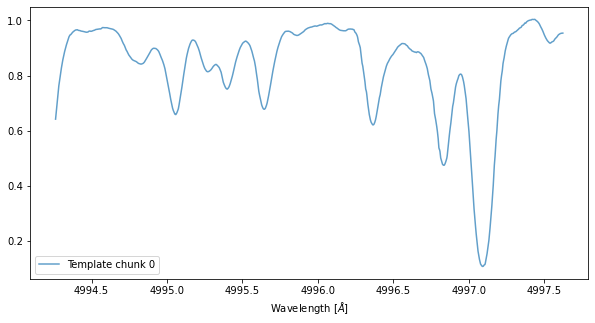

In [11]:
# Test if it can be loaded
arcturus_temp = pyodine.template.base.StellarTemplate_Chunked(temp_filepath)

# Plot template chunk to check
plot_chunk = 0

fig = plt.figure(figsize=(10,5))
plt.plot(arcturus_temp[plot_chunk].wave, arcturus_temp[plot_chunk].flux, alpha=0.7)
plt.legend(['Template chunk {}'.format(plot_chunk)])
plt.xlabel(r'Wavelength [$\AA$]')
plt.show()

Super! You are now set to use this template with Arcturus observations from SONG!